In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.colors as clrs
plt.rcParams.update({"text.usetex": True})

import math as mt
import energyflow as ef

import modplot

## Load Datasets

In [2]:
# use a fraction of the full datasets (amount=1.0 uses the full datasets)
amount =0.01

# select jets with JEC-corrected pT in [375, 425] GeV and |eta| < 1.9, with "medium" quality
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']

# stamp description of the jet selections
legend_label_0 = r'AK5 Jets, $|\eta^{\rm jet}|<1.9$'
legend_label_1 = r'$p_T^{\rm jet}\in [375, 425]$ GeV'

# load the CMS (cms), Pythia-generated (gen), and detector-simulated (sim) datasets
cms = ef.mod.load(*specs, dataset='cms', amount=amount, validate_files=True)
sim = ef.mod.load(*specs, dataset='sim', amount=amount, validate_files=True, store_gens=False)
gen = ef.mod.load(*specs, dataset='gen', amount=amount, validate_files=True)

# show the details of the CMS, SIM, and GEN datasets
print(cms)
print(sim)
print(gen)

CMS MODDataset
  Jet Integers - (48956, 6)
    ['fn' 'rn' 'lbn' 'evn' 'npv' 'quality']
  Jet Floats - (48956, 9)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'jec' 'jet_area'
     'jet_max_nef' 'weight']
  PFCs - (48956,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (1223,)

SIM MODDataset
  Jet Integers - (85819, 7)
    ['fn' 'rn' 'lbn' 'evn' 'npv' 'quality' 'hard_pid']
  Jet Floats - (85819, 17)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'jec' 'jet_area'
     'jet_max_nef' 'gen_jet_pt' 'gen_jet_y' 'gen_jet_phi' 'gen_jet_m'
     'gen_jet_eta' 'hard_pt' 'hard_y' 'hard_phi' 'weight']
  PFCs - (85819,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (2331, 2)

GEN MODDataset
  Jet Integers - (82885, 5)
    ['fn' 'rn' 'lbn' 'evn' 'hard_pid']
  Jet Floats - (82885, 9)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'hard_pt' 'hard_y'
     'hard_phi' 'weight']
  GENs - (82885,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (2331, 2)



### Define a function that calculates $\Delta\phi$ and handles periodic boundary conditions $[0, 2\pi] \rightarrow [-\pi,\pi]$

In [3]:
def deltaPhi( p1, p2):
#Computes delta phi, handling periodic limit conditions.
    res = p1 - p2
    while res > mt.pi:
        res -= 2*mt.pi
    while res < -mt.pi:
        res += 2*mt.pi
    return res 

## CMS Data

##### Add original indexes as a column to be able to later match jets with respective pfcs. 
###### Below, the final dataframe, contains ::::::::         jets_i + original index position + jets_f   arrays

In [4]:
# Create the Dataframe
cms_i_df = pd.DataFrame(cms.jets_i, columns=cms.jets_i_cols)

# Create a sample of index positions [0, 1, 2, 3, 4, .....,N-1 ,N]
col0 = np.linspace(0, len(cms.jets_i), num=len(cms.jets_i), dtype=int, endpoint=False)

# Insert those indexes into the Dataframe 
# Indexes are inserted after the final column of the original cms_df Dataframe
end = len(cms.jets_i[0])
cms_i_df.insert(end, 'index_pos', col0)

# Create a Dataframe for jets_f array
cms_f_df = pd.DataFrame(cms.jets_f, columns=cms.jets_f_cols)

# Concatenate the 2 Dataframes
cms_df = pd.concat([cms_i_df, cms_f_df], axis=1)

# Show the final Dataframe
cms_df

,fn,rn,lbn,evn,npv,quality,index_pos,jet_pt,jet_y,jet_phi,jet_m,jet_eta,jec,jet_area,jet_max_nef,weight
0,0,163270,352,219350787,9,3,0,381.967987,-1.443675,0.997096,37.292809,-1.447920,1.080041,0.817811,0.507520,0.000008
1,0,163270,352,219333672,5,3,1,387.687622,-0.671150,2.107119,47.602055,-0.675543,1.054876,0.837758,0.319022,0.000008
2,0,163270,352,219414728,8,3,2,375.403381,-1.208504,5.088523,81.933197,-1.228029,1.093916,0.777918,0.407239,0.000008
3,0,163270,352,219100041,5,3,3,364.279388,-1.146316,4.207557,49.101799,-1.153678,1.098538,0.807838,0.259200,0.000008
4,0,163270,353,220117944,5,3,4,362.900330,0.996899,0.261861,70.016815,1.010846,1.080100,0.718078,0.307451,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48951,69,165514,227,292061693,6,3,48951,372.359558,1.022831,0.138470,102.867607,1.051393,1.087773,0.927518,0.276005,0.000008
48952,69,165514,227,291348875,6,3,48952,366.482666,0.917339,5.771550,45.963692,0.923005,1.072523,0.777918,0.301487,0.000008
48953,69,165514,227,291054188,5,3,48953,389.060944,-0.099516,0.117040,22.493679,-0.099682,1.042302,0.787892,0.116589,0.000008
48954,69,165514,227,291601700,6,3,48954,382.094360,-1.839077,6.042509,45.488590,-1.845769,1.063824,0.767945,0.039775,0.000008


### Find duplicate rows

In [5]:
# Find the duplicates and sort based also on jet_pt
key = cms_df.duplicated(subset=['rn', 'lbn', 'evn'], keep=False)
cms_multijetdf = cms_df[key]
cms_multijetdf = cms_multijetdf.sort_values(by=['rn', 'lbn', 'evn','jet_pt'], axis=0, ascending=[True, True, True, False])
cms_multijetdf

###################################################

# If u want to check result, remove comment from below
#y = cms_df.value_counts(subset=['rn','lbn', 'evn']).to_frame(name='count').reset_index()
#y.loc[y['count'] == 2]
#y
####################################################

,fn,rn,lbn,evn,npv,quality,index_pos,jet_pt,jet_y,jet_phi,jet_m,jet_eta,jec,jet_area,jet_max_nef,weight
44209,62,163270,19,11581000,6,3,44209,396.280579,-0.434044,4.061552,28.942925,-0.435132,1.040877,0.757972,0.391763,0.000008
44210,62,163270,19,11581000,6,3,44210,383.399322,-0.461468,0.748706,45.129570,-0.464443,1.039648,0.787892,0.519139,0.000008
44215,62,163270,20,12490642,6,3,44215,384.363769,0.255915,6.067917,31.169455,0.256737,1.033607,0.767945,0.250696,0.000008
44216,62,163270,20,12490642,6,3,44216,383.563232,0.083641,2.925333,39.990425,0.084094,1.033942,0.767945,0.438273,0.000008
44224,62,163270,21,12949566,10,3,44224,402.191925,0.418589,4.344069,66.703331,0.423989,1.036886,0.777918,0.146167,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,58,173692,2749,3433737027,4,3,40766,373.889465,-0.273399,5.256133,21.630001,-0.273845,1.049940,0.767945,0.220487,0.000008
40767,58,173692,2749,3433907867,4,3,40767,383.144836,0.390735,2.740512,36.476120,0.392416,1.048031,0.767945,0.243746,0.000008
40768,58,173692,2749,3433907867,4,3,40768,379.778168,-0.272718,5.849816,67.255440,-0.276857,1.049779,0.757972,0.334173,0.000008
40770,58,173692,2749,3433923343,7,3,40770,389.686951,0.058330,4.131565,24.901779,0.058449,1.036739,0.797865,0.378796,0.000008


## Sim Data

In [6]:
# Create the Dataframe
sim_i_df = pd.DataFrame(sim.jets_i, columns=sim.jets_i_cols)

# Create a sample of index positions [0, 1, 2, 3, 4, .....,N-1 ,N]
col0 = np.linspace(0, len(sim.jets_i), num=len(sim.jets_i), dtype=int, endpoint=False)

# Insert those indexes into the Dataframe 
# Indexes are inserted after the final column of the original sim_df Dataframe
end = len(sim.jets_i[0])
sim_i_df.insert(end, 'index_pos', col0)

# Create a Dataframe for jets_f array
sim_f_df = pd.DataFrame(sim.jets_f, columns=sim.jets_f_cols)

# Concatenate the 2 Dataframes
sim_df = pd.concat([sim_i_df, sim_f_df], axis=1)

# Show the final Dataframe
sim_df

,fn,rn,lbn,evn,npv,quality,hard_pid,index_pos,jet_pt,jet_y,...,jet_max_nef,gen_jet_pt,gen_jet_y,gen_jet_phi,gen_jet_m,gen_jet_eta,hard_pt,hard_y,hard_phi,weight
0,334,1,15359,4377126,11,3,21,0,401.986298,-0.192344,...,0.221946,400.156109,-0.190694,4.225380,20.640513,-0.190945,398.914246,-0.193652,4.226548,4.060322e-06
1,334,1,15359,4377222,15,3,21,1,415.403107,-0.084024,...,0.436883,454.315256,-0.081125,3.762248,51.761631,-0.081648,458.659363,-0.085177,3.762930,4.060322e-06
2,334,1,17866,5091631,11,3,2,2,384.462280,0.471652,...,0.239688,375.223543,0.467812,4.225251,11.338204,0.468012,377.021759,0.468260,4.226401,4.060322e-06
3,334,1,17872,5093332,11,3,3,3,387.752350,0.827251,...,0.096971,375.343584,0.823512,3.811589,26.203996,0.825159,372.202698,0.828728,3.812265,4.060322e-06
4,334,1,17872,5093332,11,3,21,4,374.232605,0.067086,...,0.346692,370.109833,0.074949,0.708332,88.626673,0.077064,174.590805,0.267795,0.842746,4.060322e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85814,2074,1,13367,1924708,8,3,0,85814,371.799316,1.524795,...,0.239819,380.035572,1.524721,2.122314,49.118711,1.532260,-1.000000,-1.000000,-1.000000,2.174157e-10
85815,2075,1,9916,1427776,3,3,1,85815,384.269226,-0.279721,...,0.223859,1391.615740,-0.278903,0.205542,58.062433,-0.279139,1382.650757,-0.278725,0.203691,2.174157e-10
85816,2077,1,716,102979,4,3,2,85816,383.234253,-0.193887,...,0.301299,1440.806027,-0.195071,0.765541,67.734051,-0.195284,1446.881470,-0.194637,0.765812,2.174157e-10
85817,2077,1,10303,1483570,7,3,-4,85817,374.837799,0.084626,...,0.478428,405.360099,0.084066,3.598359,15.746398,0.084130,1487.877808,0.099172,3.600907,2.174157e-10


In [7]:
# Find the duplicates and sort based also on jet_pt
key = sim_df.duplicated(subset=['rn', 'lbn', 'evn'], keep=False)
sim_multijetdf = sim_df[key]
sim_multijetdf = sim_multijetdf.sort_values(by=['rn', 'lbn', 'evn','jet_pt'], axis=0, ascending=[True, True, True, False])
sim_multijetdf

###################################################

# If u want to check result, remove comment from below

#y = sim_multijetdf.value_counts(subset=['rn','lbn', 'evn']).to_frame(name='count').reset_index()
#y.loc[y['count'] == 2]
#y
####################################################

,fn,rn,lbn,evn,npv,quality,hard_pid,index_pos,jet_pt,jet_y,...,jet_max_nef,gen_jet_pt,gen_jet_y,gen_jet_phi,gen_jet_m,gen_jet_eta,hard_pt,hard_y,hard_phi,weight
37283,727,1,3,519,6,3,1,37283,399.900452,-1.014915,...,0.316024,368.495347,-1.015617,6.115013,9.533290,-1.015874,370.320068,-1.015215,6.114893,0.000005
37284,727,1,3,519,6,3,2,37284,370.064056,-0.426476,...,0.261274,397.436792,-0.423359,2.885531,48.480370,-0.426320,398.547760,-0.412661,2.882868,0.000005
37286,727,1,3,543,7,3,-1,37286,403.371063,-0.463280,...,0.726183,416.432683,-0.462980,1.360069,22.358314,-0.463602,424.624878,-0.462326,1.359082,0.000005
37287,727,1,3,543,7,3,2,37287,365.361084,-1.425226,...,0.202903,350.061606,-1.365593,4.277766,13.765034,-1.366271,370.141632,-1.417398,4.335003,0.000005
37294,727,1,3,596,5,3,2,37294,393.117737,-0.395765,...,0.370196,374.996079,-0.395500,5.883945,36.051299,-0.397234,370.340790,-0.387822,5.882631,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36007,726,1,23314,5991573,2,3,2,36007,365.678009,1.590825,...,0.458013,366.710748,1.578540,2.491448,22.893852,1.580327,366.841370,1.595296,2.494726,0.000005
36014,726,1,23314,5991618,4,3,21,36014,403.113800,-0.046801,...,0.418481,420.227332,-0.051172,5.251948,24.766073,-0.051260,426.056519,-0.051563,5.253189,0.000005
36015,726,1,23314,5991618,4,3,2,36015,386.232178,1.495615,...,0.365081,416.333731,1.484012,2.109465,33.271493,1.486885,415.247559,1.490724,2.104335,0.000005
36028,726,1,23314,5991669,10,3,2,36028,391.840820,-0.553089,...,0.612816,411.270308,-0.559073,0.179405,15.667121,-0.559441,409.390991,-0.559498,0.181456,0.000005


## Gen Data

In [8]:
# Create the Dataframe
gen_i_df = pd.DataFrame(gen.jets_i, columns=gen.jets_i_cols)

# Create a sample of index positions [0, 1, 2, 3, 4, .....,N-1 ,N]
col0 = np.linspace(0, len(gen.jets_i), num=len(gen.jets_i), dtype=int, endpoint=False)

# Insert those indexes into the Dataframe 
# Indexes are inserted after the final column of the original gen_df Dataframe
end = len(gen.jets_i[0])
gen_i_df.insert(end, 'index_pos', col0)

# Create a Dataframe for jets_f array
gen_f_df = pd.DataFrame(gen.jets_f, columns=gen.jets_f_cols)

# Concatenate the 2 Dataframes
gen_df = pd.concat([gen_i_df, gen_f_df], axis=1)

# Show the final Dataframe
gen_df

,fn,rn,lbn,evn,hard_pid,index_pos,jet_pt,jet_y,jet_phi,jet_m,jet_eta,hard_pt,hard_y,hard_phi,weight
0,334,1,15359,4377126,21,0,400.156109,-0.190694,4.225380,20.640513,-0.190945,398.914246,-0.193652,4.226548,4.060322e-06
1,334,1,17866,5091631,2,1,375.223543,0.467812,4.225251,11.338204,0.468012,377.021759,0.468260,4.226401,4.060322e-06
2,334,1,17872,5093332,3,2,375.343584,0.823512,3.811589,26.203996,0.825159,372.202698,0.828728,3.812265,4.060322e-06
3,334,1,17888,5097964,21,3,414.772677,0.107352,0.157302,37.079984,0.107778,413.556152,0.112578,0.159042,4.060322e-06
4,334,1,19384,5524253,21,4,387.208327,1.551759,0.942668,23.026032,1.553373,391.409912,1.554987,0.942876,4.060322e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82880,2075,1,9086,1308307,0,82880,397.544393,-0.464775,6.269879,20.088137,-0.465329,-1.000000,-1.000000,-1.000000,2.174352e-10
82881,2076,1,9186,1322740,-1,82881,402.801681,-0.017715,2.738991,54.834824,-0.017878,1311.853882,0.013199,2.748639,2.174352e-10
82882,2077,1,10303,1483570,-4,82882,405.360099,0.084066,3.598359,15.746398,0.084130,1487.877808,0.099172,3.600907,2.174352e-10
82883,2078,1,6699,964618,21,82883,397.075060,0.055493,0.533516,79.417030,0.056591,1448.729858,0.119846,0.494696,2.174352e-10


In [9]:
# Find the duplicates and sort based also on jet_pt
key = gen_df.duplicated(subset=['rn', 'lbn', 'evn'], keep=False)
gen_multijetdf = gen_df[key]
gen_multijetdf = gen_multijetdf.sort_values(by=['rn', 'lbn', 'evn','jet_pt'], axis=0, ascending=[True, True, True, False])
gen_multijetdf

###################################################

# If u want to check result, remove comment from below
#y = gen_multijetdf.value_counts(subset=['rn','lbn', 'evn']).to_frame(name='count').reset_index()
#y.loc[y['count'] == 1]
#y
####################################################

,fn,rn,lbn,evn,hard_pid,index_pos,jet_pt,jet_y,jet_phi,jet_m,jet_eta,hard_pt,hard_y,hard_phi,weight
36504,727,1,3,540,21,36504,397.673705,-0.602188,3.931895,36.541217,-0.604456,402.665039,-0.608033,3.929760,0.000005
36505,727,1,3,540,21,36505,397.066522,0.067893,0.800183,18.030439,0.067963,396.587585,0.068744,0.797606,0.000005
36511,727,1,3,579,21,36511,419.861619,1.042450,1.541723,61.359382,1.050697,430.274536,1.042761,1.534485,0.000005
36512,727,1,3,579,2,36512,408.995159,0.846645,4.736315,20.622373,0.847520,412.727447,0.844183,4.736973,0.000005
36513,727,1,3,586,2,36513,415.511289,-1.357966,2.766618,23.187138,-1.359328,412.805023,-1.365735,2.764165,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35198,726,1,23314,5991618,2,35198,416.333731,1.484012,2.109465,33.271493,1.486885,415.247559,1.490724,2.104335,0.000005
35209,726,1,23314,5991669,2,35209,411.270308,-0.559073,0.179405,15.667121,-0.559441,409.390991,-0.559498,0.181456,0.000005
35210,726,1,23314,5991669,21,35210,405.863529,0.046156,3.286850,62.225738,0.046695,413.766052,0.063805,3.283172,0.000005
35212,726,1,23314,5991679,2,35212,422.272492,0.718800,4.716565,15.341731,0.719207,434.821381,0.718886,4.717123,0.000005


## Make those histogramms after all

First turn dataframes into arrays

In [10]:
# Cms, Sim and Gen all-inclusive array

cms_allarr = np.asarray(cms_df)
sim_allarr = np.asarray(sim_df)
gen_allarr = np.asarray(gen_df)


# Cms, Sim and Gen multijet array

cms_multijet_arr = np.asarray(cms_multijetdf)
sim_multijet_arr = np.asarray(sim_multijetdf)
gen_multijet_arr = np.asarray(gen_multijetdf)

### 1D all-inclusive jet_pt histogramm

In [11]:
# This chuck of code belongs to mr P.Komiske
# function for getting histograms from observable values
def calc_hist(vals, log=False, bins=10, weights=None, density=True):
    
    if weights is None:
        weights = np.ones(vals.shape)
    
    # compute histogram
    hist, bins= np.histogram(vals, bins=bins, weights=weights)
    
    if log==True:
        plt.semilogy()
    # compute which bins the values are in
    digits = np.digitize(vals, bins)

    # compute the errors per bin
    # note that lowest bin value that digitize returns is 1
    # hence the range in the following list comprehension should start at 1
    errs = np.asarray([np.linalg.norm(weights[digits==i]) for i in range(1, len(bins))])
    #print(len(bins))
    #print(errs)
    # handle normalization
    if density:
        density_int = weights.sum() * (bins[1] - bins[0])
        hist /= density_int
        errs /= density_int
        
    return hist, errs, bins

### Compute histogramm

In [12]:
# Printout of columns that exist in array

# Cms
print(cms_df.columns)

# Sim
print(sim_df.columns)

# Gen
print(gen_df.columns)

Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'index_pos', 'jet_pt',
       'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'weight'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'hard_pid', 'index_pos',
       'jet_pt', 'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'gen_jet_pt', 'gen_jet_y', 'gen_jet_phi', 'gen_jet_m',
       'gen_jet_eta', 'hard_pt', 'hard_y', 'hard_phi', 'weight'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'hard_pid', 'index_pos', 'jet_pt', 'jet_y',
       'jet_phi', 'jet_m', 'jet_eta', 'hard_pt', 'hard_y', 'hard_phi',
       'weight'],
      dtype='object')


In [13]:
# define your histogram binning
alpha = gen_df['jet_pt'].min()
omega = gen_df['jet_pt'].max()
bins = np.linspace(alpha, omega, 40)

# get middle bin values and step size
step = bins[1]-bins[0]
midbins = (bins[1:] + bins[:-1])/2

# which column to hist

col0 = 7
col1 = 8
col2 = 6


# cms histogram calculation
cms_hist, cms_errs, _ = calc_hist(cms_allarr[:, col0]*cms_allarr[:, 12], bins=bins, weights=None, density=True)
cms_hist, cms_errs = cms_hist/step, cms_errs/step

# sim histogram calculation
sim_hist, sim_errs, _ = calc_hist(sim_allarr[:, col1]*sim_allarr[:, 13], bins=bins, weights=None, density=True)
sim_hist, sim_errs = sim_hist/step, sim_errs/step

# gen histogram calculation
gen_hist, gen_errs, _ = calc_hist(gen_allarr[:, col2], bins=bins, weights=None, density=True)
gen_hist, gen_errs = gen_hist/step, gen_errs/step


### Make dem plots

<IPython.core.display.Javascript object>


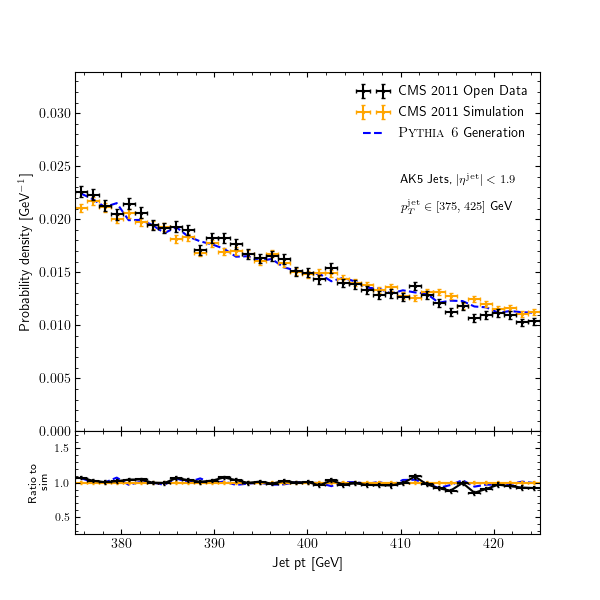

/home/lolosa/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Min of the hist is :	 375.00036289704326
        
Max of the hist is : 	 424.9997116341162


In [14]:
############################
# gridspec & figsize options
gridspec_kw = {'height_ratios': (3.5, 1), 'hspace': 0.0}
figsize = (6, 6)

##############
# get subplots
nsubplots = 2
fig, axes = plt.subplots(nrows=nsubplots, gridspec_kw=gridspec_kw, figsize=figsize)

#############
# axes limits
xlim=(min(bins), max(bins))
ylim=(0, 1.5*np.max(cms_hist))
ylim_ratio=(0.25, 1.75)
      
for ax in axes:
    ax.set_xlim(xlim)

axes[0].set_ylim(ylim)
axes[1].set_ylim(ylim_ratio)  

##########################################
# define the x-axis label and y-axis label
xlabel = r'Jet pt '
ylabel = 'Probability density'
units='GeV'
ylabel_ratio='Ratio to\nsim'

xlabel = r'{} [{}]'.format(xlabel, units)
ylabel = r'{} [{}{}]'.format(ylabel, units, r'$^{-1}$')
axes[-1].set_xlabel(xlabel)
axes[-1].set_ylabel(ylabel_ratio, fontsize=8)
axes[0].set_ylabel(ylabel)

###############
# Tick settings
for ax in axes:
    ax.minorticks_on()
    ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].tick_params(axis='y', labelsize=8)

################################################################################################
################################################################################################

# tiny regulator
reg = 10**-30

# plot of the cms observable distribution
cms_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'black', 
             'label':'CMS 2011 Open Data'}
axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2, yerr=cms_errs/(sim_hist+reg), 
                **cms_style, zorder=2)

# plot of the sim observable distribution
sim_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'orange', 
             'label':'CMS 2011 Simulation'}
axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2, yerr=sim_errs/(sim_hist+reg), 
                **sim_style, zorder=1)

# plot of the gen observable distribution
gen_style = {'lw': 1.5, 'ls': '--', 'color': 'blue', 'label': r'\textsc{Pythia 6} Generation'}
axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
axes[1].plot(midbins, gen_hist/(sim_hist + reg), **gen_style, zorder=0)

# additional plot modifications

stamp_x, stamp_y = 0.70, 0.70
modplot.stamp(stamp_x, stamp_y, ax=axes[0], 
              line_0=legend_label_0, line_1=legend_label_1)
modplot.legend(ax=axes[0], order=[1, 2, 0])

# save plot (by default in the same directory as this notebook).
# The MOD logo can be optionally added by changing add_watermark to True in the following command.
modplot.save(fig, 'All-jet_pt-jec', add_watermark=False, tx=51.5, ty=251.5, plots_dir='.')


fig.show()

# Print min and max value of histogramm

print(f'''Min of the hist is :\t {alpha}
        \nMax of the hist is : \t {omega}''')

## Hardest jet pt hist

Dataframe already sorted. For duplicate lines, 1st occurence includes hard jet 

In [15]:
# For Cms
cms_hardjet = np.asarray(cms_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='first'))
cms_softjet = np.asarray(cms_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='last'))

# For Sim
sim_hardjet = np.asarray(sim_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='first'))
sim_softjet = np.asarray(sim_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='last'))

# For Gen
gen_hardjet = np.asarray(gen_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='first'))
gen_softjet = np.asarray(gen_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='last'))

In [16]:
# Printout of columns that exist in array

# Cms
print(cms_multijetdf.columns)

# Sim
print(sim_multijetdf.columns)

# Gen
print(gen_multijetdf.columns)

Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'index_pos', 'jet_pt',
       'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'weight'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'hard_pid', 'index_pos',
       'jet_pt', 'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'gen_jet_pt', 'gen_jet_y', 'gen_jet_phi', 'gen_jet_m',
       'gen_jet_eta', 'hard_pt', 'hard_y', 'hard_phi', 'weight'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'hard_pid', 'index_pos', 'jet_pt', 'jet_y',
       'jet_phi', 'jet_m', 'jet_eta', 'hard_pt', 'hard_y', 'hard_phi',
       'weight'],
      dtype='object')


## Histogramms

In [17]:
# define your histogram binning
alpha = gen_df['jet_pt'].min()
omega = gen_df['jet_pt'].max()
bins = np.linspace(alpha, omega, 40)

# get middle bin values and step size
step = bins[1]-bins[0]
midbins = (bins[1:] + bins[:-1])/2

# which column to hist

col0 = 7
col1 = 8
col2 = 6


# cms histogram calculation
cms_hist, cms_errs, _ = calc_hist(cms_hardjet[:, col0]*cms_hardjet[:, 12], bins=bins, weights=None, density=True)
cms_hist, cms_errs = cms_hist/step, cms_errs/step

# sim histogram calculation
sim_hist, sim_errs, _ = calc_hist(sim_hardjet[:, col1]*sim_hardjet[:, 13], bins=bins, weights=None, density=True)
sim_hist, sim_errs = sim_hist/step, sim_errs/step

# gen histogram calculation
gen_hist, gen_errs, _ = calc_hist(gen_hardjet[:, col2], bins=bins, weights=None, density=True)
gen_hist, gen_errs = gen_hist/step, gen_errs/step

<IPython.core.display.Javascript object>


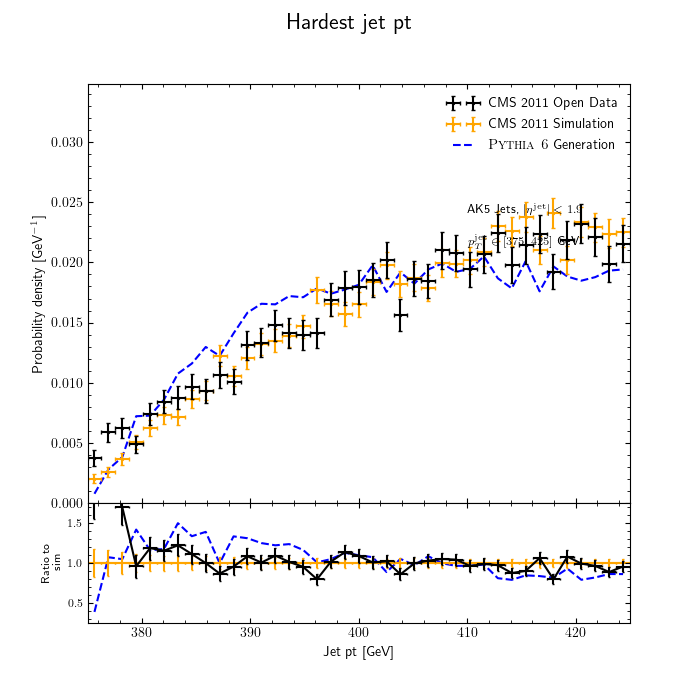

/home/lolosa/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Min of the hist is :	 375.00036289704326
        
Max of the hist is : 	 424.9997116341162


In [18]:
############################
# gridspec & figsize options
gridspec_kw = {'height_ratios': (3.5, 1), 'hspace': 0.0}
figsize = (7, 7)

##############
# get subplots
nsubplots = 2
fig, axes = plt.subplots(nrows=nsubplots, gridspec_kw=gridspec_kw, figsize=figsize)

#############
# axes limits
xlim=(min(bins), max(bins))
ylim=(0, 1.5*np.max(cms_hist))
ylim_ratio=(0.25, 1.75)
      
for ax in axes:
    ax.set_xlim(xlim)

axes[0].set_ylim(ylim)
axes[1].set_ylim(ylim_ratio)  

##########################################
# define the x-axis label and y-axis label & Titel
titel = 'Hardest jet pt'
xlabel = r'Jet pt '
ylabel = 'Probability density'
units='GeV'
ylabel_ratio='Ratio to\nsim'

xlabel = r'{} [{}]'.format(xlabel, units)
ylabel = r'{} [{}{}]'.format(ylabel, units, r'$^{-1}$')
axes[-1].set_xlabel(xlabel)
axes[-1].set_ylabel(ylabel_ratio, fontsize=8)
axes[0].set_ylabel(ylabel)

###############
# Tick settings
for ax in axes:
    ax.minorticks_on()
    ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].tick_params(axis='y', labelsize=8)

################################################################################################
################################################################################################

# tiny regulator
reg = 10**-30

# plot of the cms observable distribution
cms_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'black', 
             'label':'CMS 2011 Open Data'}
axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2, yerr=cms_errs/(sim_hist+reg), 
                **cms_style, zorder=2)

# plot of the sim observable distribution
sim_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'orange', 
             'label':'CMS 2011 Simulation'}
axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2, yerr=sim_errs/(sim_hist+reg), 
                **sim_style, zorder=1)

# plot of the gen observable distribution
gen_style = {'lw': 1.5, 'ls': '--', 'color': 'blue', 'label': r'\textsc{Pythia 6} Generation'}
axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
axes[1].plot(midbins, gen_hist/(sim_hist + reg), **gen_style, zorder=0)

# additional plot modifications

stamp_x, stamp_y = 0.70, 0.70
modplot.stamp(stamp_x, stamp_y, ax=axes[0], 
              line_0=legend_label_0, line_1=legend_label_1)
modplot.legend(ax=axes[0], order=[1, 2, 0])

# save plot (by default in the same directory as this notebook).
# The MOD logo can be optionally added by changing add_watermark to True in the following command.
modplot.save(fig, 'Hard-jet_pt-jec', add_watermark=False, tx=51.5, ty=251.5, plots_dir='.')

fig.suptitle(titel, fontsize=16)
fig.show()

# Print min and max value of histogramm

print(f'''Min of the hist is :\t {alpha}
        \nMax of the hist is : \t {omega}''')

## Softer jet pt hist

In [19]:
# define your histogram binning
alpha = gen_df['jet_pt'].min()
omega = gen_df['jet_pt'].max()
bins = np.linspace(alpha, omega, 40)

# get middle bin values and step size
step = bins[1]-bins[0]
midbins = (bins[1:] + bins[:-1])/2

# which column to hist

col0 = 7
col1 = 8
col2 = 6


# cms histogram calculation
cms_hist, cms_errs, _ = calc_hist(cms_softjet[:, col0]*cms_softjet[:, 12], bins=bins, weights=None, density=True)
cms_hist, cms_errs = cms_hist/step, cms_errs/step

# sim histogram calculation
sim_hist, sim_errs, _ = calc_hist(sim_softjet[:, col1]*sim_softjet[:, 13], bins=bins, weights=None, density=True)
sim_hist, sim_errs = sim_hist/step, sim_errs/step

# gen histogram calculation
gen_hist, gen_errs, _ = calc_hist(gen_softjet[:, col2], bins=bins, weights=None, density=True)
gen_hist, gen_errs = gen_hist/step, gen_errs/step

<IPython.core.display.Javascript object>


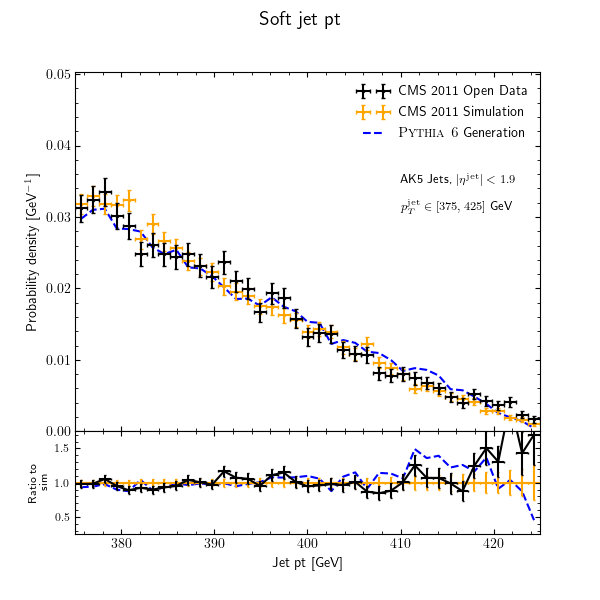

/home/lolosa/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Min of the hist is :	 375.00036289704326
        
Max of the hist is : 	 424.9997116341162


In [20]:
############################
# gridspec & figsize options
gridspec_kw = {'height_ratios': (3.5, 1), 'hspace': 0.0}
figsize = (6, 6)

##############
# get subplots
nsubplots = 2
fig, axes = plt.subplots(nrows=nsubplots, gridspec_kw=gridspec_kw, figsize=figsize)

#############
# axes limits
xlim=(min(bins), max(bins))
ylim=(0, 1.5*np.max(cms_hist))
ylim_ratio=(0.25, 1.75)
      
for ax in axes:
    ax.set_xlim(xlim)

axes[0].set_ylim(ylim)
axes[1].set_ylim(ylim_ratio)  

##########################################
# define the x-axis label and y-axis label & Titel
titel = 'Soft jet pt'
xlabel = r'Jet pt '
ylabel = 'Probability density'
units='GeV'
ylabel_ratio='Ratio to\nsim'

xlabel = r'{} [{}]'.format(xlabel, units)
ylabel = r'{} [{}{}]'.format(ylabel, units, r'$^{-1}$')
axes[-1].set_xlabel(xlabel)
axes[-1].set_ylabel(ylabel_ratio, fontsize=8)
axes[0].set_ylabel(ylabel)

###############
# Tick settings
for ax in axes:
    ax.minorticks_on()
    ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].tick_params(axis='y', labelsize=8)

################################################################################################
################################################################################################

# tiny regulator
reg = 10**-30

# plot of the cms observable distribution
cms_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'black', 
             'label':'CMS 2011 Open Data'}
axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2, yerr=cms_errs/(sim_hist+reg), 
                **cms_style, zorder=2)

# plot of the sim observable distribution
sim_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'orange', 
             'label':'CMS 2011 Simulation'}
axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2, yerr=sim_errs/(sim_hist+reg), 
                **sim_style, zorder=1)

# plot of the gen observable distribution
gen_style = {'lw': 1.5, 'ls': '--', 'color': 'blue', 'label': r'\textsc{Pythia 6} Generation'}
axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
axes[1].plot(midbins, gen_hist/(sim_hist + reg), **gen_style, zorder=0)

# additional plot modifications

stamp_x, stamp_y = 0.70, 0.70
modplot.stamp(stamp_x, stamp_y, ax=axes[0], 
              line_0=legend_label_0, line_1=legend_label_1)
modplot.legend(ax=axes[0], order=[1, 2, 0])

# save plot (by default in the same directory as this notebook).
# The MOD logo can be optionally added by changing add_watermark to True in the following command.
modplot.save(fig, 'Soft-jet_pt-jec', add_watermark=False, tx=51.5, ty=251.5, plots_dir='.')

fig.suptitle(titel, fontsize=14)
fig.show()

# Print min and max value of histogramm

print(f'''Min of the hist is :\t {alpha}
        \nMax of the hist is : \t {omega}''')